In [1]:
import jax

jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)
jax.config.update("jax_platform_name", "cpu")

from typing import Callable

import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from jaxtyping import Array

import optimal_control.controls as controls
import optimal_control.solvers as solvers
import optimal_control.trainers as trainers
from optimal_control.environments.examples.active_fibrosis import (
    FibrosisEnvironment,
    FibrosisState,
)

# Training an agent

In [2]:
key = jax.random.PRNGKey(1234)


class CustomControl(controls.AbstractControl):
    input_transform_fn: Callable[[Array], Array]
    wrapped_control: controls.AbstractControl

    def __call__(self, y: Array) -> Array:
        return jax.nn.sigmoid(self.wrapped_control(self.input_transform_fn(y)))

    """
    def __call__(self, z: Array, dX: Array, y: Array) -> Array:
        ln_dX = jnp.concatenate((dX[..., :1], dX[..., 1:] / y), axis=-1) * 0.1
        dz = self.wrapped_control(z) @ ln_dX[..., :2]
        return dz

        #return jnp.zeros(4)

    def encode_latents(self, y: Array) -> Array:
        y = jnp.concatenate((y[..., :1], self.input_transform_fn(y[..., 1:])), axis=-1)
        return self.wrapped_control.encode_latents(y)
        # return self.wrapped_control.encode_latents(y[..., :2]) * 0.0
        #return jnp.zeros(4)

    def decode_latents(self, z: Array) -> Array:
        return jax.nn.sigmoid(self.wrapped_control.decode_latents(z))
        # return jnp.zeros(2)
    """


def transform_fn(y: Array) -> Array:
    return jnp.log10(y[..., :1])


key, subkey = jax.random.split(key)
"""
control = controls.ModularControl(
    hidden_width=64,
    hidden_layers=2,
    num_controls=2,
    num_latents=4,
    num_states=1,
    rnn_cell_type=None,
    key=subkey,
)
"""
control = controls.Siren(
    in_features=1, out_features=2, hidden_features=64, hidden_layers=2, key=subkey
)
control = CustomControl(transform_fn, control)

environment: FibrosisEnvironment = FibrosisEnvironment()
solver = solvers.DirectSolver(
    optimizer=optax.adamw(learning_rate=1e-4, weight_decay=1e-2), num_control_points=-1
)


def reward_fn(ys: Array) -> float:
    # num_fm = ys[..., :2]
    # return jnp.sum(jnp.where(num_fm > 1e2, jnp.log(num_fm), 0.0))

    return ys[..., 4]


key, subkey = jax.random.split(key)

In [3]:
optimized_reward, optimized_control = trainers.solve_optimal_control_problem(
    num_train_steps=1024,
    environment=environment,
    reward_fn=reward_fn,
    constraint_chain=[],
    solver=solver,
    control=control,
    key=subkey,
    pbar_interval=8,
)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [5]:
eqx.tree_serialise_leaves("/home/lena/master-thesis/repos/optimal-control/results/active_fibrosis/healthy_steady_state_y0/direct_control/control.eqx", control)

In [4]:
key = jax.random.PRNGKey(1)
state = environment.init()
#y1, y_interp = environment.integrate(controls.LambdaControl(copy_data, jnp.full((2,), 0.0)), state, key, dense=True)
(y1, y_interp), influx_events = environment.integrate(optimized_control, state, key, throw=True, dense=True, ret_influx_events=True)
#y1, y_interp = environment.integrate(control, state, key, dense=True, throw=True)

In [5]:
import diffrax
from typing import Any


def plot_direct_control_figures(
    interpolation: diffrax.DenseInterpolation,
    control: controls.AbstractControl,
    influx_events: Array,
    *,
    show: bool = True,
    save: bool = True,
    output_path: str = "",
    style: str = "seaborn-paper",
):
    # Make data
    ts = jnp.linspace(0.0, 1000.0, 1001)
    ys = jax.vmap(lambda t: interpolation.evaluate(t))(ts)
    cs = jax.vmap(lambda t: control(interpolation.evaluate(t)))(ts)

    n_fibroblasts = jnp.geomspace(
        jnp.min(ys[..., 0]) * 0.5, jnp.max(ys[..., 0]) * 2.0, 1024
    ).reshape(-1, 1)
    c_fibroblasts = jax.vmap(lambda n: control(n))(n_fibroblasts)

    # Output helper
    def _handle_output(figure_filepath: str):
        if save:
            plt.savefig(f"{output_path}/{figure_filepath}.png", bbox_inches="tight")
            plt.savefig(f"{output_path}/{figure_filepath}.svg", bbox_inches="tight")

        if show:
            plt.show()
        else:
            plt.close()

    with plt.style.context("seaborn-paper"):
        # Line plot of fibroblast-macrophage trajectory
        plt.figure()
        plt.yscale("log")
        plt.xlabel("Time")
        plt.ylabel("# of cells")
        for t in influx_events:
            plt.axvline(t, c="tab:red", linestyle="--")
        plt.plot(ts, ys[..., 0], label="Fibroblasts")
        plt.plot(ts, ys[..., 1], label="Macrophages")
        plt.legend()
        _handle_output("fm_trajectory.png")

        plt.figure()
        plt.xlabel("Time")
        plt.ylabel("Control Values")
        plt.ylim([-0.01, jnp.max(cs) + 0.01])
        for t in influx_events:
            plt.axvline(t, c="tab:red", linestyle="--")
        plt.plot(ts, cs[..., 0], label="anti-PDGF1-ab")
        plt.plot(ts, cs[..., 1], label="anti-CSFa-ab")
        plt.legend()
        _handle_output("control_trajectory.png")

        plt.figure()
        plt.xlabel("# of Fibroblasts")
        plt.ylabel("Control Values")
        plt.xscale("log")
        # plt.xlim([jnp.min(ys[..., 0]) * 0.5, jnp.max(ys[..., 0]) * 2.0])
        plt.plot(n_fibroblasts, c_fibroblasts[..., 0], label="anti-PDGF1-ab")
        plt.plot(n_fibroblasts, c_fibroblasts[..., 1], label="anti-CSFa-ab")
        # plt.axvline(jnp.min(ys[..., 0]), c="tab:red")
        # plt.axvline(jnp.max(ys[..., 0]), c="tab:red")
        _handle_output("control_phasespace")

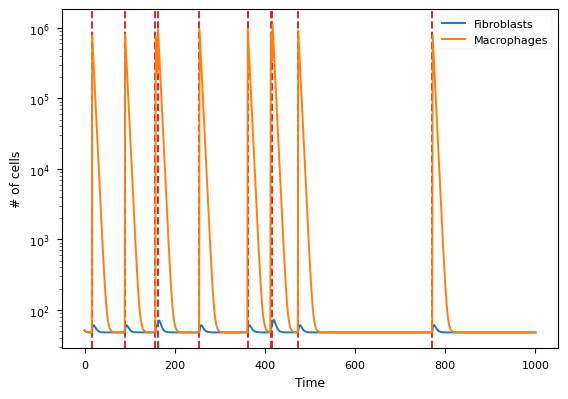

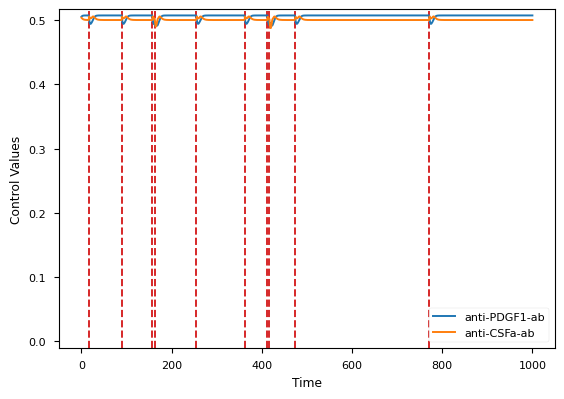

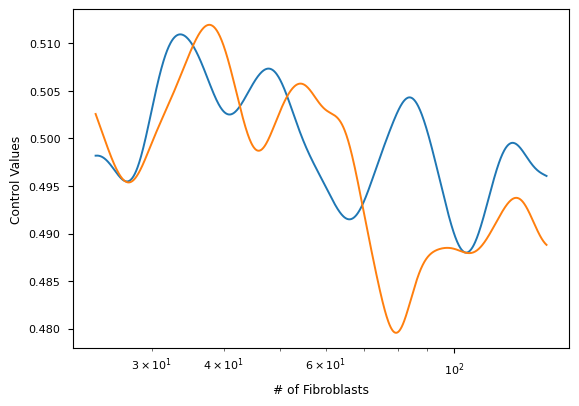

In [6]:
key = jax.random.PRNGKey(1)
state = environment.init()
(_, interpolation), influx_events = environment.integrate(
    optimized_control,
    state,
    key,
    max_steps=5000,
    throw=True,
    dense=True,
    ret_influx_events=True,
)

plot_direct_control_figures(interpolation, optimized_control, influx_events, save=False)

In [6]:
optimized_reward

Array(-14718.24954863, dtype=float64, weak_type=True)

In [ ]:
# CDE

ts = jnp.linspace(0.0, 1000.0, 1001)
ys = jax.vmap(lambda t: y_interp.evaluate(t))(ts)
cs = jax.vmap(lambda t: optimized_control.decode_latents(y_interp.evaluate(t)[..., -4:]))(ts)

#n_fibroblasts = jnp.geomspace(jnp.min(ys[..., 0]) * 0.5, jnp.max(ys[..., 0]) * 2.0, 1024).reshape(-1, 1)
#c_fibroblasts = jax.vmap(lambda n: optimized_control(n))(n_fibroblasts)

with plt.style.context("seaborn-paper"):
    output_path = "/home/lena/master-thesis/repos/optimal-control/results/active_fibrosis/cde_control"

    plt.figure()
    plt.yscale("log")
    plt.xlabel("Time")
    plt.ylabel("# of cells")
    for t in influx_events:
        plt.axvline(t, c="tab:red", linestyle="--")
    plt.plot(ts, ys[..., 0], label="Fibroblasts")
    plt.plot(ts, ys[..., 1], label="Macrophages")
    plt.legend()
    plt.savefig(f"{output_path}/fm_trajectory.png", bbox_inches="tight")
    plt.savefig(f"{output_path}/fm_trajectory.svg", bbox_inches="tight")
    plt.show()

    plt.figure()
    plt.xlabel("Time")
    plt.ylabel("Control Values")
    plt.ylim([-0.01, jnp.max(cs) + 0.01])
    for t in influx_events:
        plt.axvline(t, c="tab:red", linestyle="--")
    plt.plot(ts, cs[..., 0], label="anti-PDGF1-ab")
    plt.plot(ts, cs[..., 1], label="anti-CSFa-ab")
    plt.legend()
    plt.savefig(f"{output_path}/control_trajectory.png", bbox_inches="tight")
    plt.savefig(f"{output_path}/control_trajectory.svg", bbox_inches="tight")
    plt.show()

In [ ]:
plt.figure()
plt.xlabel("Time")
plt.ylabel("Latent Value")
for t in influx_events:
    plt.axvline(t, c="tab:red", linestyle="--")
plt.plot(ts, ys[..., -4:], label="CDE Latents")
plt.legend()
plt.show()

In [ ]:
# Direct

ts = jnp.linspace(0.0, 1000.0, 1001)
ys = jax.vmap(lambda t: y_interp.evaluate(t))(ts)
cs = jax.vmap(lambda t: optimized_control(y_interp.evaluate(t)))(ts)

n_fibroblasts = jnp.geomspace(jnp.min(ys[..., 0]) * 0.5, jnp.max(ys[..., 0]) * 2.0, 1024).reshape(-1, 1)
c_fibroblasts = jax.vmap(lambda n: optimized_control(n))(n_fibroblasts)

with plt.style.context("seaborn-paper"):
    output_path = "/home/lena/master-thesis/repos/optimal-control/results/active_fibrosis/cde_control"

    plt.figure()
    plt.yscale("log")
    plt.xlabel("Time")
    plt.ylabel("# of cells")
    for t in influx_events:
        plt.axvline(t, c="tab:red", linestyle="--")
    plt.plot(ts, ys[..., 0], label="Fibroblasts")
    plt.plot(ts, ys[..., 1], label="Macrophages")
    plt.legend()
    plt.savefig(f"{output_path}/fm_trajectory.png", bbox_inches="tight")
    plt.savefig(f"{output_path}/fm_trajectory.svg", bbox_inches="tight")
    plt.show()

    plt.figure()
    plt.xlabel("Time")
    plt.ylabel("Control Values")
    plt.ylim([-0.01, jnp.max(cs) + 0.01])
    for t in influx_events:
        plt.axvline(t, c="tab:red", linestyle="--")
    plt.plot(ts, cs[..., 0], label="anti-PDGF1-ab")
    plt.plot(ts, cs[..., 1], label="anti-CSFa-ab")
    plt.legend()
    plt.savefig(f"{output_path}/control_trajectory.png", bbox_inches="tight")
    plt.savefig(f"{output_path}/control_trajectory.svg", bbox_inches="tight")
    plt.show()

    plt.figure()
    plt.xlabel("# of Fibroblasts")
    plt.ylabel("Control Values")
    plt.xscale("log")
    #plt.xlim([jnp.min(ys[..., 0]) * 0.5, jnp.max(ys[..., 0]) * 2.0])
    plt.plot(n_fibroblasts, c_fibroblasts[..., 0], label="anti-PDGF1-ab")
    plt.plot(n_fibroblasts, c_fibroblasts[..., 1], label="anti-CSFa-ab")
    #plt.axvline(jnp.min(ys[..., 0]), c="tab:red")
    #plt.axvline(jnp.max(ys[..., 0]), c="tab:red")
    plt.savefig(f"{output_path}/control_phasespace.png", bbox_inches="tight")
    plt.savefig(f"{output_path}/control_phasespace.svg", bbox_inches="tight")
    plt.legend()
    plt.show()

# Manual testing with the environment

In [ ]:
import diffrax

control = eqx.nn.MLP(in_size=1, out_size=1, width_size=64, depth=2, key=jax.random.PRNGKey(1234))

@eqx.filter_value_and_grad
def integrate(control):
    return diffrax.diffeqsolve(
        terms=diffrax.ODETerm(lambda t, y, args: args(y)),
        solver=diffrax.Euler(),
        t0=0.0,
        t1=10.0,
        dt0=0.1,
        y0=jnp.zeros(1),
        max_steps=10,
        throw=False,
        args=control,
    ).ys[-1, 0]

integrate(control)[1].layers[0].weight

In [ ]:
environment: FibrosisEnvironment = FibrosisEnvironment()
state = environment.init()

In [ ]:
#influx_sequence = environment._sample_influx_sequence_twostate(t0=0.0, t1=1000.0, dt=1.0, p01=0.01, p10=0.25, key=jax.random.PRNGKey(1))
influx_sequence = environment._sample_influx_sequence_random(t0=0.0, t1=1000.0, dt=4.0, p1=0.04, key=jax.random.PRNGKey(1))

plt.figure()
plt.plot(influx_sequence)
plt.show()

In [ ]:
influx_events = environment._sample_influx_events(t0=0.0, t1=1000.0, n=10, key=jax.random.PRNGKey(0))
influx_events

In [ ]:
key = jax.random.PRNGKey(2)
state = environment.init()

@eqx.filter_value_and_grad
def integrate(control):
    return environment.integrate(control, state, key, dense=False, throw=True)[..., 4]

x = integrate(control)

In [ ]:
def copy_data(_, data):
    return data

In [ ]:
key = jax.random.PRNGKey(1)
(y1, y_interp), influx_events = environment.integrate(controls.LambdaControl(copy_data, jnp.full((2,), 0.0)), state, key, dense=True, ret_influx_events=True)
#y1, y_interp, influx_events = environment.integrate(optimized_control, state, key, throw=True, dense=True, ret_influx_events=True)
#y1, y_interp = environment.integrate(control, state, key, dense=True, throw=True)

In [ ]:
ts = jnp.linspace(0.0, 1000.0, 1001)
ys = jax.vmap(lambda t: y_interp.evaluate(t))(ts)
#cs = jax.vmap(lambda t: optimized_control(y_interp.evaluate(t)))(ts)

#n_fibroblasts = jnp.geomspace(1e0, 1e4, 1024).reshape(-1, 1)
#c_fibroblasts = jax.vmap(lambda n: optimized_control(n))(n_fibroblasts)

plt.figure()
plt.yscale("log")
plt.xlabel("Time")
plt.ylabel("# of cells")
plt.plot(ts, ys[..., 0], label="Fibroblasts")
plt.plot(ts, ys[..., 1], label="Macrophages")
for t in influx_events:
    plt.axvline(t, c="tab:red")
plt.legend()
plt.show()

plt.figure()
plt.xlabel("Time")
plt.ylabel("Control Values")
plt.ylim([-0.01, jnp.max(cs) + 0.01])
plt.plot(ts, cs[..., 0], label="anti-PDGF1-ab")
plt.plot(ts, cs[..., 1], label="anti-CSFa-ab")
for t in influx_events:
    plt.axvline(t, c="tab:red")
plt.legend()
plt.show()

plt.figure()
plt.xlabel("# of Fibroblasts")
plt.ylabel("Control Values")
plt.xscale("log")
plt.plot(n_fibroblasts, c_fibroblasts[..., 0], label="anti-PDGF1-ab")
plt.plot(n_fibroblasts, c_fibroblasts[..., 1], label="anti-CSFa-ab")
plt.axvline(jnp.min(cs), c="tab:red")
plt.axvline(jnp.max(cs), c="tab:red")
plt.legend()
plt.show()

In [ ]:
jnp.max(ys[..., 0])

In [ ]:
y_interp.infos["y0"][256:256+128, 0]

In [ ]:
import optimal_control
from optimal_control.environments.examples.active_fibrosis import (
    _fibrosis_ode,
    _fibrosis_reward,
)

ode = optimal_control.with_control(
    optimal_control.with_extra_term(
        _fibrosis_ode, g=_fibrosis_reward, num_g_states=1, g0=jnp.zeros(1)
    )
)

ode._modify_initial_state(None, None, jnp.zeros(0))

In [ ]:
plt.figure()
plt.yscale("log")
plt.plot(ys.ys)
plt.show()

In [ ]:
ys